In [1]:
import numpy as np
import time
import pickle
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras


In [2]:

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7836811436843227547
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5486479364478364813
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
tf.random.set_seed(8)

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niladrisaikia","key":"f537725a200403f242f0a46c8f74da3b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:

!kaggle datasets download splcher/animefacedataset

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 98% 388M/395M [00:03<00:00, 99.6MB/s]
100% 395M/395M [00:03<00:00, 105MB/s] 


In [7]:

! kaggle datasets download ashwingupta3012/human-faces

Dataset URL: https://www.kaggle.com/datasets/ashwingupta3012/human-faces
License(s): CC0-1.0
 98% 1.77G/1.82G [00:11<00:00, 233MB/s]
100% 1.82G/1.82G [00:11<00:00, 174MB/s]


In [8]:
! unzip animefacedataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [9]:
! unzip human-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: Humans/1 (2910).jpg     
  inflating: Humans/1 (2911).jpg     
  inflating: Humans/1 (2912).jpg     
  inflating: Humans/1 (2913).jpg     
  inflating: Humans/1 (2914).jpg     
  inflating: Humans/1 (2915).jpg     
  inflating: Humans/1 (2916).jpg     
  inflating: Humans/1 (2917).jpg     
  inflating: Humans/1 (2918).jpg     
  inflating: Humans/1 (2919).jpg     
  inflating: Humans/1 (292).jpg      
  inflating: Humans/1 (2920).jpg     
  inflating: Humans/1 (2921).jpg     
  inflating: Humans/1 (2922).jpg     
  inflating: Humans/1 (2923).jpg     
  inflating: Humans/1 (2924).jpg     
  inflating: Humans/1 (2925).jpg     
  inflating: Humans/1 (2926).jpg     
  inflating: Humans/1 (2927).jpg     
  inflating: Humans/1 (2928).jpg     
  inflating: Humans/1 (2929).jpg     
  inflating: Humans/1 (293).jpg      
  inflating: Humans/1 (2930).jpg     
  inflating: Humans/1 (2931).jpg     
  inflating: Humans/1 (2932).jpg     

In [10]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
batch_size =1
BUFFER_SIZE = 1000

In [ ]:
#Addressed PS1
#What is to be addressed: image resize causes distortion and reduce image quality
#My approach: 1.used bilinear interpolation instead of nearest neighbour for jitter

In [53]:
def resize(image):
  image= tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image


def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def preprocess_image(image):
  image = resize(image)
  image = random_crop(image)
  image = random_jitter(image)
  return image

def random_jitter(image):
  if IMG_HEIGHT == 256:
    jitter = 286
  elif IMG_HEIGHT == 128:
    jitter = 144
  else:
    jitter = IMG_HEIGHT + 20

  image = tf.image.resize(image, [jitter,jitter],
                                method=tf.image.ResizeMethod.BILINEAR)
  image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  image = tf.image.random_flip_left_right(image)
  return image


In [54]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array


DATASET_DIR = "/content/images"
IMG_SIZE = (128, 128)
TRAIN_SIZE = 1000
TEST_SIZE = 100


all_images = [os.path.join(DATASET_DIR, f) for f in os.listdir(DATASET_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]


trainB, testB = train_test_split(all_images, test_size=TEST_SIZE, train_size=TRAIN_SIZE, random_state=42)


def load_and_preprocess_images(image_paths, img_size):
    images = []
    for path in image_paths:

        img = load_img(path, target_size=img_size)
        img = img_to_array(img)
        img = (img / 256)
        images.append(img)
    return np.array(images)

trainB_data = load_and_preprocess_images(trainB, IMG_SIZE)
testB_data = load_and_preprocess_images(testB, IMG_SIZE)
np.save("trainB.npy", trainB_data)
np.save("testB.npy", testB_data)

print(f"Train data shape: {trainB_data.shape}")
print(f"Test data shape: {testB_data.shape}")


Train data shape: (1000, 128, 128, 3)
Test data shape: (100, 128, 128, 3)


In [55]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array


DATASET_DIR = "/content/Humans"
IMG_SIZE = (128, 128)
TRAIN_SIZE = 1000
TEST_SIZE = 100

all_images = [os.path.join(DATASET_DIR, f) for f in os.listdir(DATASET_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]

trainB, testB = train_test_split(all_images, test_size=TEST_SIZE, train_size=TRAIN_SIZE, random_state=42)

def load_and_preprocess_images(image_paths, img_size):
    images = []
    for path in image_paths:
        # Load image
        img = load_img(path, target_size=img_size)
        img = img_to_array(img)
        img = (img / 256)
        images.append(img)
    return np.array(images)

trainA_data = load_and_preprocess_images(trainB, IMG_SIZE)
testA_data = load_and_preprocess_images(testB, IMG_SIZE)

np.save("trainA.npy", trainA_data)
np.save("testA.npy", testA_data)

print(f"Train data shape: {trainA_data.shape}")
print(f"Test data shape: {testA_data.shape}")


Train data shape: (1000, 128, 128, 3)
Test data shape: (100, 128, 128, 3)


In [56]:
for image in trainA_data :
  image=preprocess_image(image)


In [57]:
for image in trainB_data :
  image=preprocess_image(image)

for image in testA_data :
  image=preprocess_image(image)

for image in testB_data :
  image=preprocess_image(image)

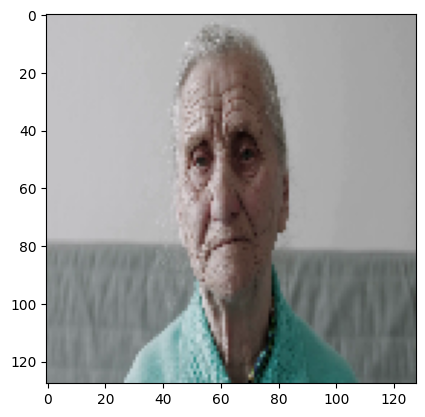

In [58]:
plt.imshow(trainA_data[0])
plt.show()

In [59]:
sampleA = next(iter(trainA_data))
sampleB = next(iter(trainB_data))

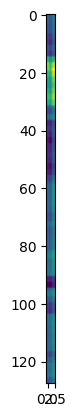

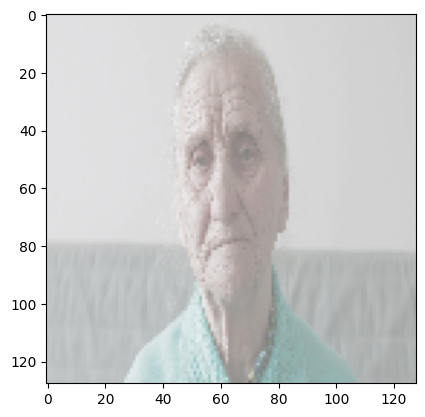

In [60]:
plt.imshow(sampleB[0] * 0.5 + 0.5)
plt.show()
plt.imshow(trainA_data[0]*0.5+0.5)

In [61]:
def get_norm_layer(norm):
  if norm == 'instance_norm':
    return tf.keras.layers.LayerNormalization
  elif norm == 'layer_norm':
    return tf.keras.layers.LayerNormalization
weight_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
initializer = weight_init

In [62]:
def Generator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = get_norm_layer(norm)


    def _residual_block(x):
        dim = x.shape[-1]
        h = x
        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()
        h = tf.nn.relu

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    h = inputs = keras.Input(shape=input_shape)
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False, kernel_initializer=initializer)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)

    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    for _ in range(n_blocks):
        h = _residual_block(h)

    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid', kernel_initializer=initializer)(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)

In [63]:
def Discriminator(input_shape=(256, 256, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):
    dim_ = dim
    Norm = get_norm_layer(norm)

    h = inputs = keras.Input(shape=input_shape)

    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', kernel_initializer=initializer)(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)

    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False, kernel_initializer=initializer)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(h)

    return keras.Model(inputs=inputs, outputs=h)

In [64]:

class ItemPool:

    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.items = []

    def __call__(self, in_items):

        if self.pool_size == 0:
            return in_items

        out_items = []
        for in_item in in_items:
            if len(self.items) < self.pool_size:
                self.items.append(in_item)
                out_items.append(in_item)
            else:
                if np.random.rand() > 0.5:
                    idx = np.random.randint(0, len(self.items))
                    out_item, self.items[idx] = self.items[idx], in_item
                    out_items.append(out_item)
                else:
                    out_items.append(in_item)
        return tf.stack(out_items, axis=0)

In [52]:


if IMG_HEIGHT >= 256:
    numberOfblocks = 9
else:
    numberOfblocks = 6

GXY = Generator(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=numberOfblocks,
                    norm='instance_norm')

FYX = Generator(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=numberOfblocks,
                    norm='instance_norm')

DY = Discriminator(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm')
DX = Discriminator(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


pool_size = 50
XY_pool = ItemPool(pool_size)
YX_pool = ItemPool(pool_size)

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


**COMPLETE FUTHER PROJECT**